# Load the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
df = pd.read_csv('./drive/MyDrive/Projects/exchange-rate/data/Foreign_Exchange_Rates.csv')
# Convert the entire DataFrame to numeric
selected_columns = df.loc[:, df.columns != 'Time Serie']
selected_columns = selected_columns.apply(pd.to_numeric, errors='coerce')
df.update(selected_columns)
df['Time Serie'] = pd.to_datetime(df['Time Serie'])
df['Time Serie']

# Pre-process the data

In [3]:
# Fill ND values with previous and next values
df = df.replace("ND", np.nan)
df = df.bfill().ffill()

In [4]:
num = df.isnull().sum()
len(df)

5217

In [5]:
print("Total number of days between {} and {} are {}".format(df['Time Serie'].min().date(), df['Time Serie'].max().date(), (df['Time Serie'].max() - df['Time Serie'].min()).days+1))

Total number of days between 2000-01-03 and 2019-12-31 are 7303


In [5]:
# Prepare a full dataframe
num_records = (df['Time Serie'].max() - df['Time Serie'].min()).days+1
data = {}
data["Time Serie"] = pd.date_range(df['Time Serie'].min().date(), df['Time Serie'].max().date(), freq="D")

df_full = pd.DataFrame(data=data)
# df_full = df_full.set_index("DATE")
df_full = df_full.merge(df, left_index=True, right_index=True, how="left")
df_full = df_full.bfill().ffill()

In [ ]:
df_full.head

In [ ]:
# compute all the exchange rates wrt. Norway
cols = [col.replace("US$", "Norway-NOK") for col in df.columns]
nor_df = pd.DataFrame(data = df, columns=cols)
nor_df.iloc[:, 2:] = df.iloc[:, 2:].div(df['NORWAY - NORWEGIAN KRONE/US$'], axis=0)
nor_df.iloc[:, 2:] = nor_df.iloc[:, 2:].applymap(lambda x: 1/x)
nor_df['US$/Norway_NOK'] = df['NORWAY - NORWEGIAN KRONE/US$']

nor_df.head


In [5]:
nor_df = nor_df.drop(columns = ['NORWAY - NORWEGIAN KRONE/Norway-NOK'])


In [8]:
nor_df.to_csv('./drive/MyDrive/Projects/exchange-rate/data/norway-exchangerate')

In [6]:
def scatter_plot(df, country):
  selected_col = [col for col in df.columns if country.lower() in col.lower()]
  selected_col.insert(0, 'Time Serie')
  df_show = df[selected_col]
  for index in range(len(selected_col) - 1):
    # plot
    plt.figure(figsize=(18,6))
    # size and color:
    plt.scatter(df_show['Time Serie'], df_show.iloc[:,index + 1])
    plt.title(df_show.columns[index+1], fontsize = 20,fontweight = 'bold', color='blue')
    plt.xlabel("Date", fontsize = 14, fontweight='bold', color='red')
    plt.ylabel('Exchange Rate', fontsize = 14, fontweight='bold', color='red')
    plt.show()

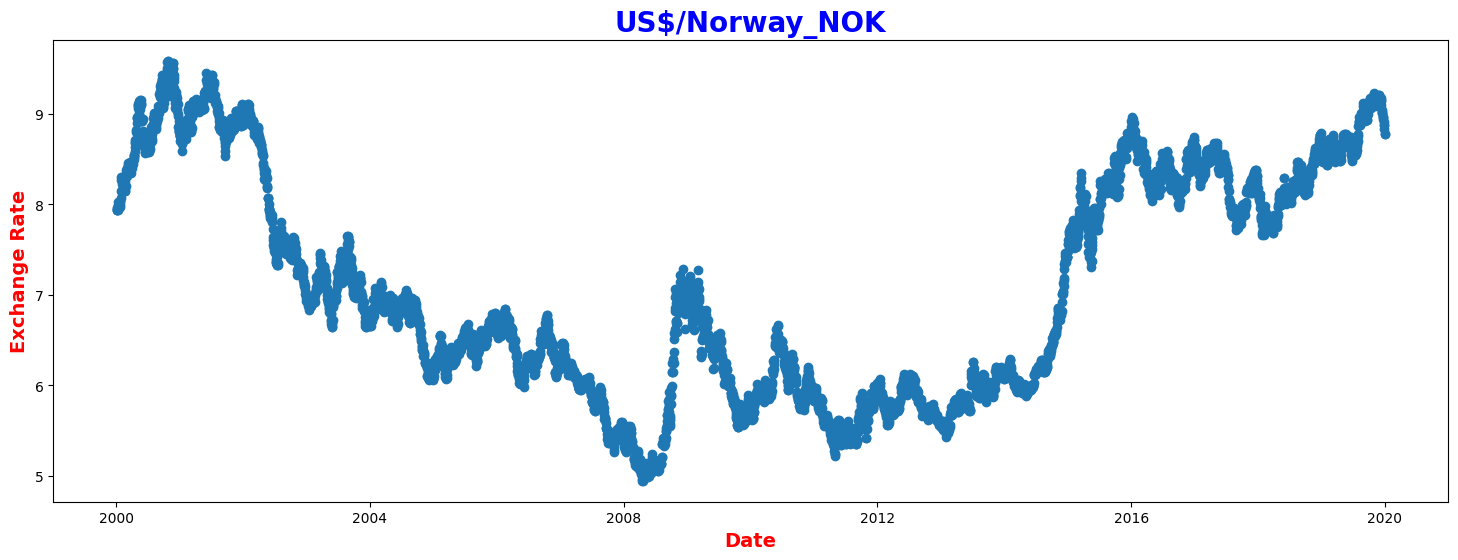

In [10]:
scatter_plot(nor_df, "US$")

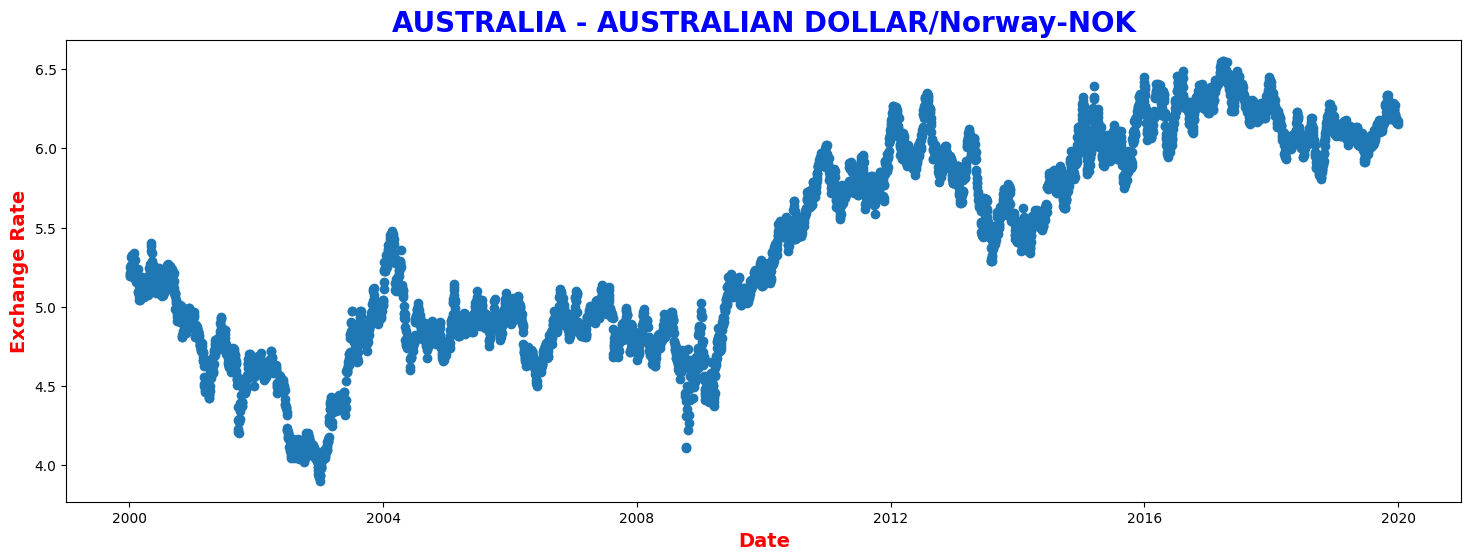

In [13]:
scatter_plot(nor_df, 'AUSTRALIA')

## predict US$/NOK using LSTM

In [26]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
#Defining the LSTM model
from keras.models import Sequential
from keras.layers import Dense,LSTM
import torch

In [75]:
us_nok_data = nor_df['US$/Norway_NOK'] #get the exchange rate between US and Norway
data = np.array(us_nok_data).reshape(-1, 1)

In [9]:
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [76]:
#Training and test sets
train = data[:4700]
test = data[4700:]

print(train.shape)
print(test.shape)

(4700, 1)
(517, 1)


In [77]:
def get_IO_data(data, input_window, predict_window):
  datax, datay = [],[]
  for i in range(len(data)-input_window-predict_window):
    datax.append(data[i:(i+input_window),0])
    datay.append(data[i+input_window:(i+input_window+predict_window),0])
  return np.array(datax) , np.array(datay)

In [78]:
input_window = 60
predict_window = 15

train_X, train_Y = get_IO_data(train, input_window=input_window, predict_window=predict_window)
# np.save('./drive/MyDrive/Projects/exchange-rate/data/nor-exr-train-x', train_X)
# np.save('./drive/MyDrive/Projects/exchange-rate/data/nor-exr-train-y', train_Y)
print(train_X.shape)
print(train_Y.shape)

(4625, 60)
(4625, 15)


In [79]:
test_X, test_Y = get_IO_data(test, input_window=input_window, predict_window=predict_window)
# np.save('./drive/MyDrive/Projects/exchange-rate/data/nor-exr-test-x', test_X)
# np.save('./drive/MyDrive/Projects/exchange-rate/data/nor-exr-test-y', test_Y)
print(test_X.shape)
print(test_Y.shape)

(442, 60)
(442, 15)


In [ ]:
print(test_X[:10])
print(test_Y[:10])

In [46]:
#Processing train and test sets for LSTM model
num_feature = 1

train_X = train_X.reshape(train_X.shape[0],train_X.shape[1], num_feature)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1], num_feature)
print(train_X.shape)
print(test_X.shape)

(4625, 60, 1)
(442, 60, 1)


In [30]:
model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=(input_window, num_feature)))
model.add(Dense(predict_window))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 15)                1515      
                                                                 
Total params: 42,315
Trainable params: 42,315
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.compile(optimizer='adam', loss = 'mse')

In [43]:
#Training
model.fit(train_X,train_Y, epochs = 20, batch_size=32)

Epoch 1/20
145/145 [==============================] - 17s 116ms/step - loss: 0.0012
Epoch 2/20
145/145 [==============================] - 17s 116ms/step - loss: 0.0012
Epoch 3/20
145/145 [==============================] - 17s 117ms/step - loss: 0.0011
Epoch 4/20
145/145 [==============================] - 18s 123ms/step - loss: 0.0011
Epoch 5/20
145/145 [==============================] - 18s 126ms/step - loss: 0.0011
Epoch 6/20
145/145 [==============================] - 17s 118ms/step - loss: 0.0011
Epoch 7/20
145/145 [==============================] - 17s 116ms/step - loss: 0.0011
Epoch 8/20
145/145 [==============================] - 17s 115ms/step - loss: 0.0011
Epoch 9/20
145/145 [==============================] - 20s 137ms/step - loss: 0.0011
Epoch 10/20
145/145 [==============================] - 19s 129ms/step - loss: 0.0010
Epoch 11/20
145/145 [==============================] - 17s 117ms/step - loss: 0.0011
Epoch 12/20
145/145 [==============================] - 17s 116ms/step - lo

In [47]:
pred_Y = model.predict(test_X)
pred_Y = scaler.inverse_transform(pred_Y) #inverse scaler

14/14 [==============================] - 0s 10ms/step


In [49]:
#Processing test shape
test_Y = np.array(test_Y).reshape(-1,predict_window)
test_Y = scaler.inverse_transform(test_Y)
test_Y.shape

(442, 15)

In [ ]:
print(test_Y[:10])

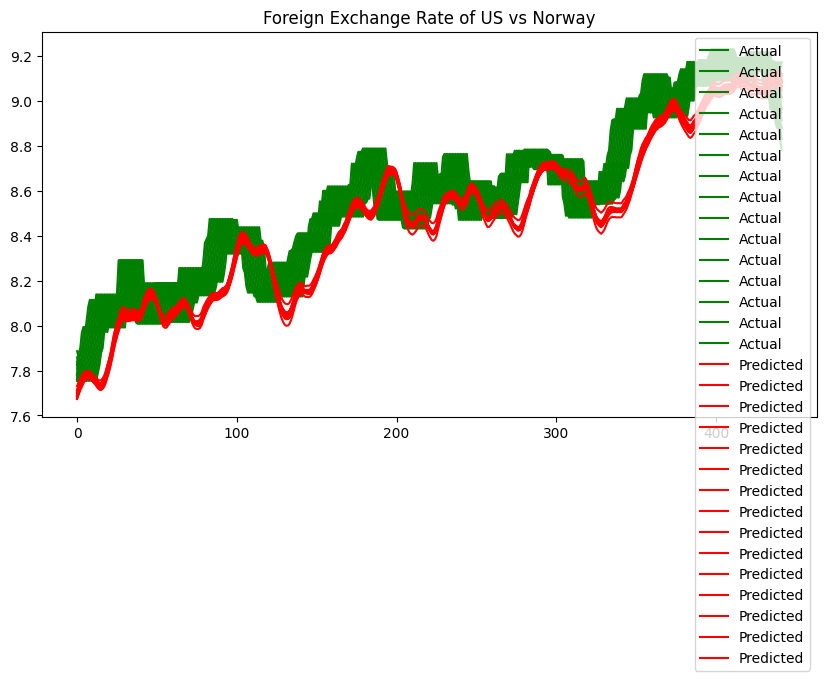

In [40]:
#Visualizing the results
plt.figure(figsize=(10,5))
plt.title('Foreign Exchange Rate of US vs Norway')
plt.plot(test_Y , label = 'Actual', color = 'g')
plt.plot(pred_Y , label = 'Predicted', color = 'r')
plt.legend()

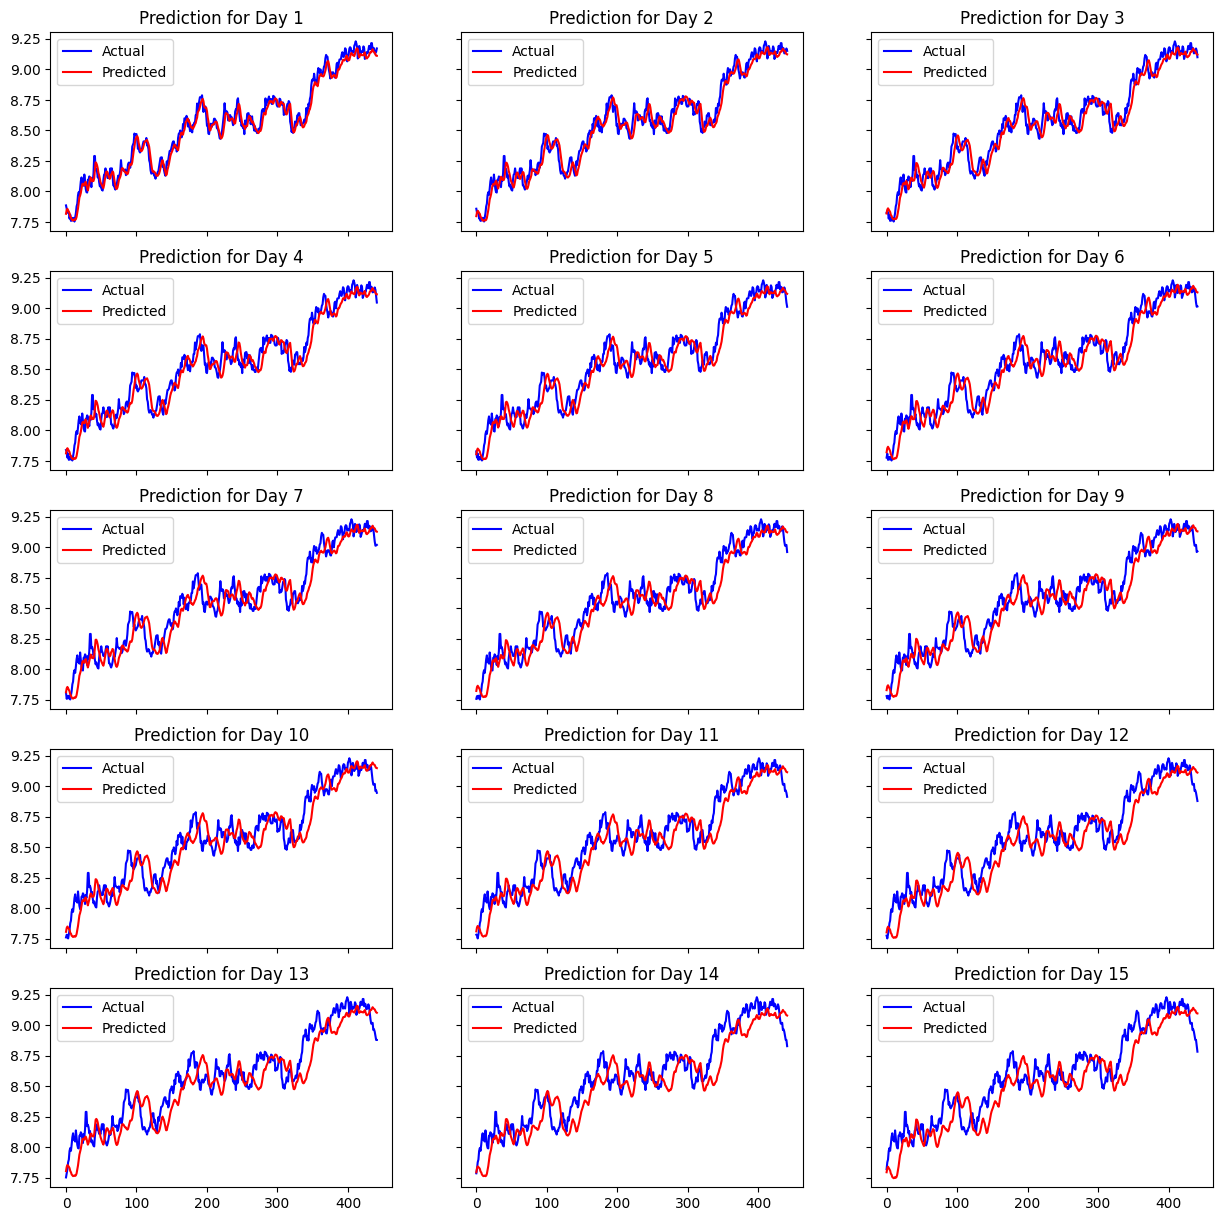

In [50]:
#Visualizing each day prediction results
# plt.figure(figsize=(30,25))
# plt.title('Foreign Exchange Rate of US vs Norway')

fig, axs = plt.subplots(5, 3, sharex='all', sharey='all', figsize=(15,15))

for i in range(predict_window):
  axs[i//3, i%3].plot(test_Y[:, i] , label = 'Actual', color = 'b')
  axs[i//3, i%3].plot(pred_Y[:, i] , label = 'Predicted', color = 'r')
  axs[i//3, i%3].title.set_text(f"Prediction for Day {i+1}")
  axs[i//3, i%3].legend()

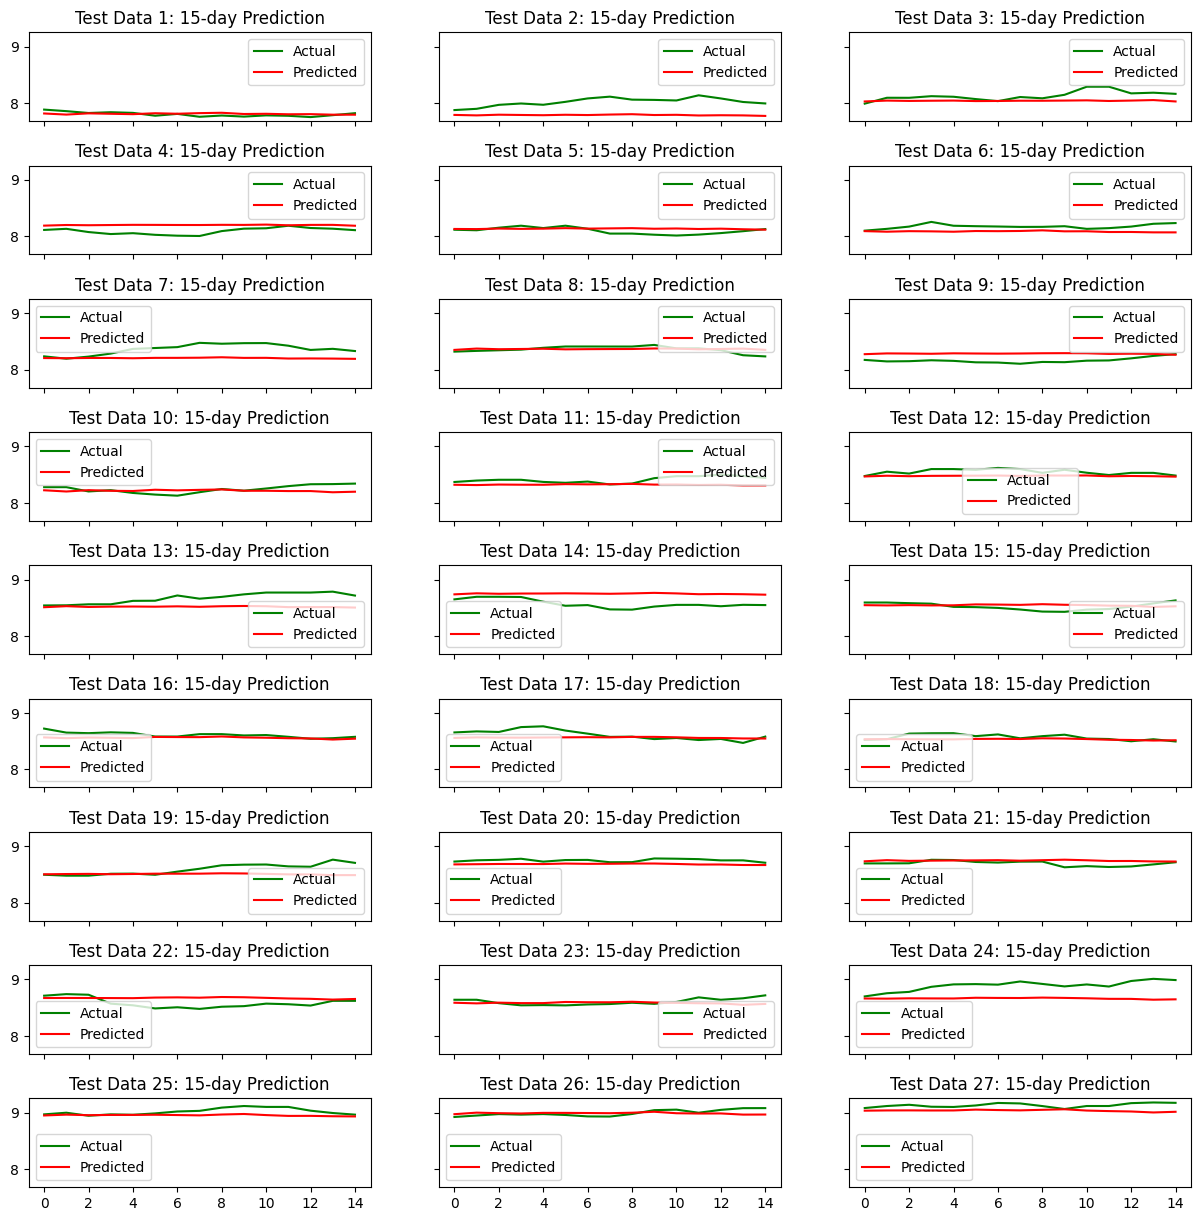

In [51]:
#Visualizing 15 test data for next 15 days prediction results

num_testdata = test_Y.shape[0] // predict_window
num_row = num_testdata // 3
fig, axs = plt.subplots(num_row, 3, sharex='all', sharey='all', figsize=(15,15))
plt.subplots_adjust(hspace=0.5)

for i in range(num_row * 3):
  axs[i//3, i%3].plot(test_Y[predict_window * i, :] , label = 'Actual', color = 'g')
  axs[i//3, i%3].plot(pred_Y[predict_window * i, :] , label = 'Predicted', color = 'r')
  axs[i//3, i%3].title.set_text(f"Test Data {i+1}: 15-day Prediction")
  axs[i//3, i%3].legend()

In [52]:
from sklearn.metrics import mean_squared_error
print((f"Prediction MSE for ALL"))
print(mean_squared_error(test_Y, pred_Y))
for i in range(predict_window):
  print((f"Prediction MSE for Day {i+1}"))
  print(mean_squared_error(test_Y[:, i], pred_Y[:, i]))

Prediction MSE for ALL
0.014008814415928087
Prediction MSE for Day 1
0.0029707397057708936
Prediction MSE for Day 2
0.004957042757545307
Prediction MSE for Day 3
0.006521373536043887
Prediction MSE for Day 4
0.00849827981994767
Prediction MSE for Day 5
0.010293268451553185
Prediction MSE for Day 6
0.011428002199020734
Prediction MSE for Day 7
0.01301776773801749
Prediction MSE for Day 8
0.014133407591171954
Prediction MSE for Day 9
0.015039892612245073
Prediction MSE for Day 10
0.01674914697354834
Prediction MSE for Day 11
0.01811121598427688
Prediction MSE for Day 12
0.01984027239256461
Prediction MSE for Day 13
0.02069604990727664
Prediction MSE for Day 14
0.023186176448528623
Prediction MSE for Day 15
0.024689580121410048


# Predict US$/Norway-NOK using DLinear

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class PredictionModel(nn.Module):
    """
    Decomposition-Linear
    """
    def __init__(self, configs):
        super(PredictionModel, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.device = configs.device

        # Decompsition Kernel Size
        kernel_size = 25
        self.decompsition = series_decomp(kernel_size)
        self.individual = configs.individual
        self.channels = configs.enc_in

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()

            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))

                # Use this two lines if you want to visualize the weights
                # self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                # self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)

            # Use this two lines if you want to visualize the weights
            # self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
            # self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]


In [54]:
from torch.utils.data import IterableDataset
from torch.utils.data import DataLoader
import random
import pandas as pd
import numpy as np
import os


class EXDataset(IterableDataset):
    def __init__(self, filepath, batch_size):
        self.filepath = filepath
        self.batch_size = batch_size

    def __iter__(self):
        return self

    def __next__(self):
        data = np.load(self.filepath)
        batches = np.array_split(data, len(data) // self.batch_size)
        for batch in batches:
            yield batch


In [55]:
class Config():

  def __init__(self, seq_len, pred_len, individual, enc_in, device, kernel_size=25):
    self.seq_len = seq_len
    self.pred_len = pred_len
    self.individual = individual
    self.enc_in = enc_in
    self.kernel_size = kernel_size
    self.device = device

  def get_seq_len(self):
    return self.seq_len
  def set_seq_len(self, value):
    self.seq_len = value

  def get_pred_len(self):
      return self.pred_len
  def set_pred_len(self, value):
    self.pred_len = value

  def get_individual(self):
    return self.individual
  def set_individual(self, value):
    self.individual = value

  def get_enc_in(self):
    return self.enc_in
  def set_enc_in(self, value):
    self.enc_in = value

  def get_device(self):
    return self.device
  def set_device(self, value):
    self.device = value

  def get_kernel_size(self):
    return self.kernel_size
  def set_kernel_size(self, value):
    self.kernel_size = value

In [91]:
import time
import numpy as np
import tensorflow as tf


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
configs = Config(seq_len=60, pred_len=15, individual=False, enc_in=1, device=device, kernel_size = 7)
model = PredictionModel(configs).to(device)

epochs = 700
batch_size = 32
lr = 0.00005

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

filepath = './drive/MyDrive/Projects/exchange-rate/data/'
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
start_time = time.time()
train_loss = []

for epoch in range(epochs):
  train_x = EXDataset(filepath + 'nor-exr-train-x.npy', batch_size)
  train_y = EXDataset(filepath + 'nor-exr-train-y.npy', batch_size)
  x_batches = next(iter(train_x))
  y_batches = next(iter(train_y))
  for x, y in zip(x_batches, y_batches):
    x = torch.from_numpy(x.astype(np.float32)).to(device)
    y = torch.from_numpy(y.astype(np.float32)).to(device)
    x = x.reshape(x.shape[0],x.shape[1], model.channels) #(batch, output_len, channel)
    y_pred = model(x)
    y_pred = y_pred.reshape(-1,y_pred.shape[1]) #(batch * channel, output_len)
    assert y_pred.shape == y.shape, f"y_pred shape is not equal to y shape"
    # print(y_pred[:5,:])
    # print(y[:5,:])
    loss = criterion(y_pred, y)
    train_loss.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f"average train loss: {np.average(train_loss)}")
  train_loss = []

best_model_path = filepath + 'checkpoint.pth'
torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, best_model_path)


#Predict
# model.load_state_dict(torch.load(best_model_path)['model_state_dict'])
test_x = EXDataset(filepath+'nor-exr-test-x.npy', batch_size)
x_batches = next(iter(test_x))
y = np.load(filepath+'nor-exr-test-y.npy')
y = torch.from_numpy(y.astype(np.float32))

outputs = []
with torch.no_grad():
  for x in x_batches:
    x = torch.from_numpy(x.astype(np.float32)).to(device)
    x = x.reshape(x.shape[0],x.shape[1], model.channels) #(batch, output_len, channel)
    output = model(x).detach().cpu().numpy()
    output = output.reshape(-1,output.shape[1]) #(batch * channel, output_len)
    print(f"output shape:{output.shape}")
    outputs.append(output)

y_pred = tf.concat(outputs, axis=0)
print(y.shape)



average train loss: 64.93902375962999
average train loss: 38.17752483155992
average train loss: 21.410698546303642
average train loss: 11.444734715753132
average train loss: 5.790513591633903
average train loss: 2.7634091542826758
average train loss: 1.2504183043622308
average train loss: 0.5504051391035318
average train loss: 0.2530079961547421
average train loss: 0.13797908449648982
average train loss: 0.09782277221610355
average train loss: 0.08525891918947713
average train loss: 0.08172367574621199
average train loss: 0.08077149508689116
average train loss: 0.08044503848456468
average train loss: 0.08023372218142161
average train loss: 0.0800281635116941
average train loss: 0.07981198106426746
average train loss: 0.0795852641620311
average train loss: 0.0793494491727971
average train loss: 0.07910527399831659
average train loss: 0.07885302335812917
average train loss: 0.07859281818188417
average train loss: 0.07832476012279382
average train loss: 0.07804884896743008
average train l

In [64]:
print(y_pred[:2,])

tf.Tensor(
[[8.443352 8.412683 8.399856 8.384832 8.393003 8.445415 8.467898 8.459065
  8.453934 8.420559 8.417962 8.413466 8.413878 8.385641 8.383041]
 [8.4993   8.477481 8.439601 8.425118 8.429707 8.475131 8.472361 8.48055
  8.445355 8.445993 8.434844 8.435956 8.397882 8.381201 8.375506]], shape=(2, 15), dtype=float32)


In [109]:
print(y[:2,])

tensor([[8.5507, 8.6015, 8.6631, 8.6739, 8.6766, 8.6434, 8.6371, 8.7627, 8.7056,
         8.7287, 8.7509, 8.7591, 8.7785, 8.7273, 8.7556],
        [8.6015, 8.6631, 8.6739, 8.6766, 8.6434, 8.6371, 8.7627, 8.7056, 8.7287,
         8.7509, 8.7591, 8.7785, 8.7273, 8.7556, 8.7580]])


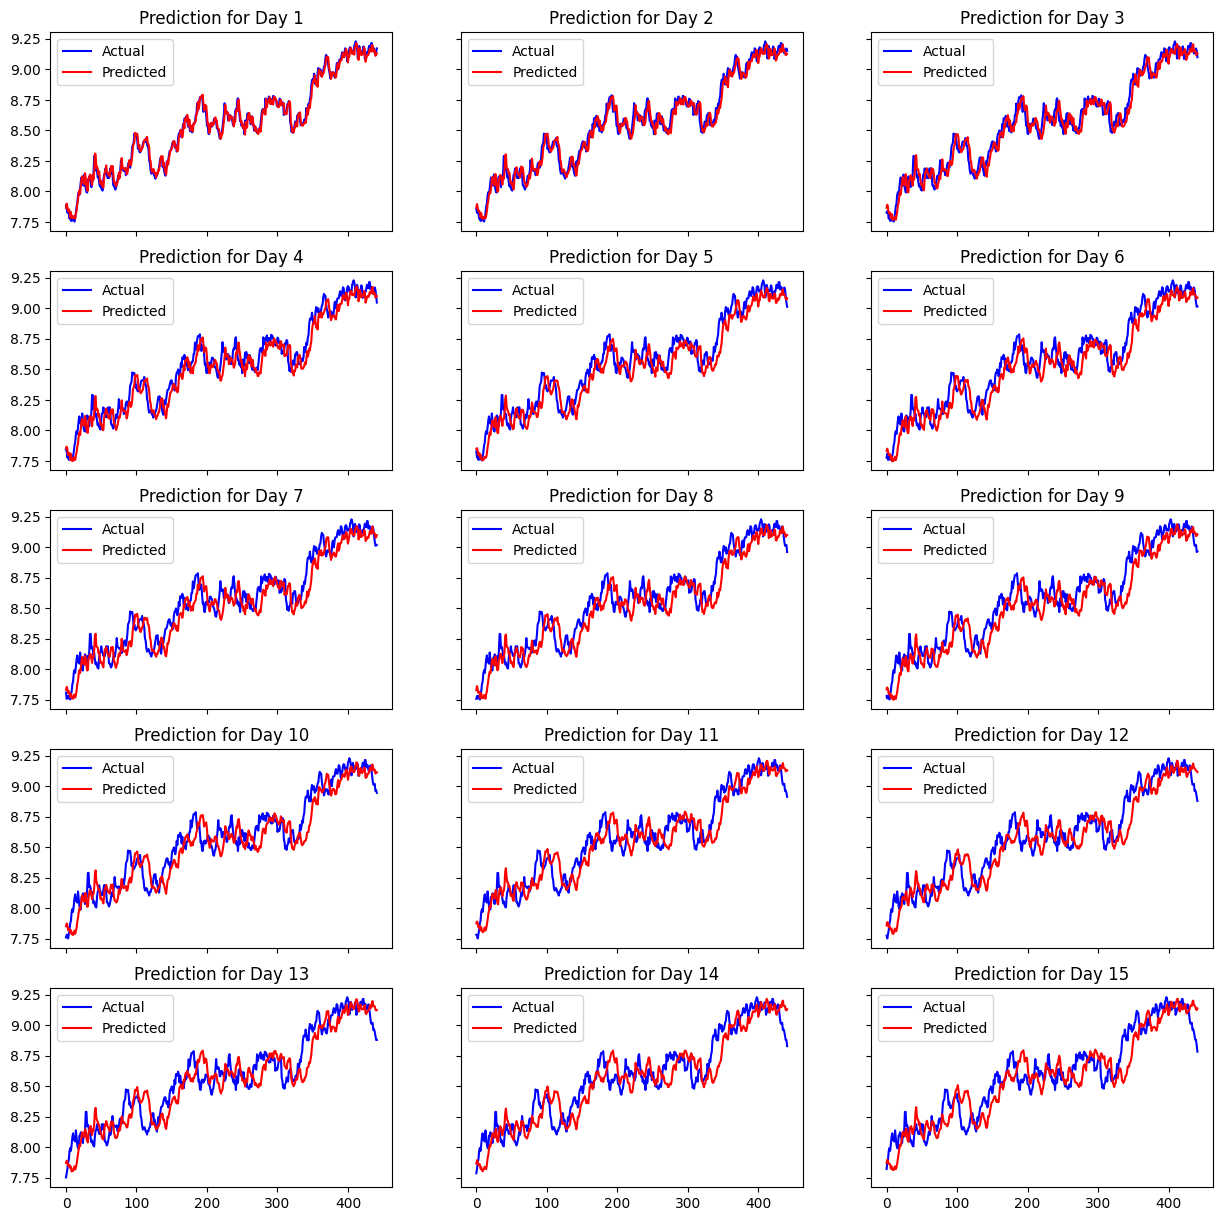

In [94]:
fig, axs = plt.subplots(5, 3, sharex='all', sharey='all', figsize=(15,15))

for i in range(configs.get_pred_len()):
  axs[i//3, i%3].plot(y[:, i] , label = 'Actual', color = 'b')
  axs[i//3, i%3].plot(y_pred[:, i] , label = 'Predicted', color = 'r')
  axs[i//3, i%3].title.set_text(f"Prediction for Day {i+1}")
  axs[i//3, i%3].legend()

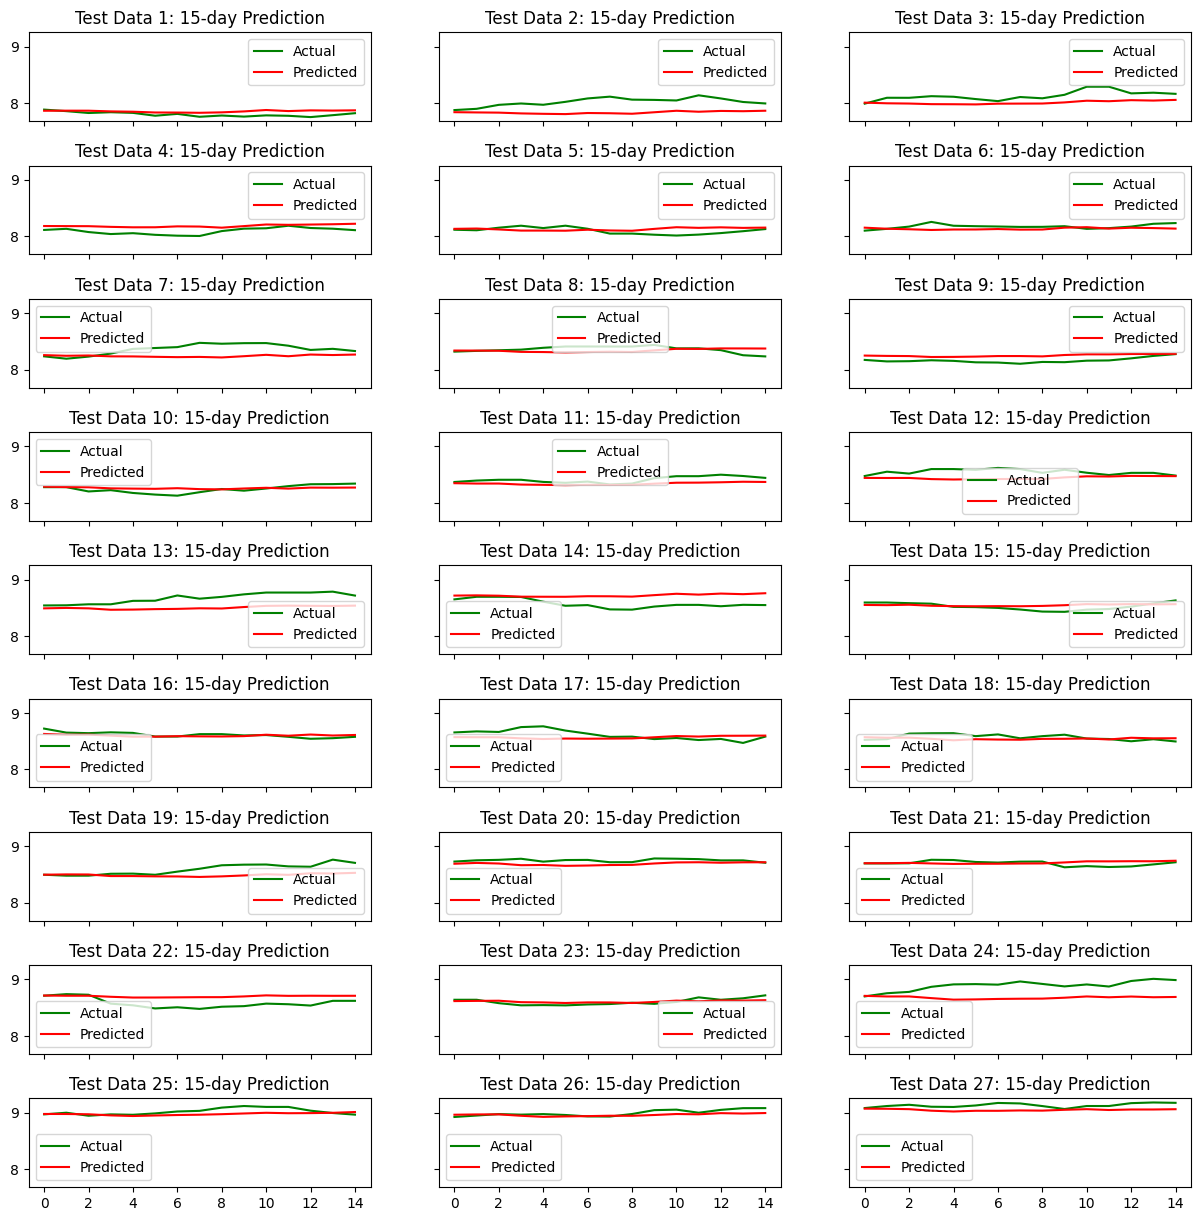

In [95]:
#Visualizing 15 test data for next 15 days prediction results

num_testdata = y.shape[0] // predict_window
num_row = num_testdata // 3
fig, axs = plt.subplots(num_row, 3, sharex='all', sharey='all', figsize=(15,15))
plt.subplots_adjust(hspace=0.5)

for i in range(num_row * 3):
  axs[i//3, i%3].plot(y[predict_window * i, :] , label = 'Actual', color = 'g')
  axs[i//3, i%3].plot(y_pred[predict_window * i, :] , label = 'Predicted', color = 'r')
  axs[i//3, i%3].title.set_text(f"Test Data {i+1}: 15-day Prediction")
  axs[i//3, i%3].legend()

In [96]:
from sklearn.metrics import mean_squared_error
print((f"Prediction MSE for ALL"))
print(mean_squared_error(y, y_pred))
for i in range(predict_window):
  print((f"Prediction MSE for Day {i+1}"))
  print(mean_squared_error(y[:, i], y_pred[:, i]))

Prediction MSE for ALL
0.013180631
Prediction MSE for Day 1
0.0017928215
Prediction MSE for Day 2
0.003560158
Prediction MSE for Day 3
0.0053462754
Prediction MSE for Day 4
0.008392045
Prediction MSE for Day 5
0.0112815965
Prediction MSE for Day 6
0.012659664
Prediction MSE for Day 7
0.013649203
Prediction MSE for Day 8
0.015175758
Prediction MSE for Day 9
0.016701352
Prediction MSE for Day 10
0.016507242
Prediction MSE for Day 11
0.016693357
Prediction MSE for Day 12
0.017994583
Prediction MSE for Day 13
0.018436708
Prediction MSE for Day 14
0.01936434
Prediction MSE for Day 15
0.02015437


# Predicting US$/Norway-NOK using NLinear

# Predict US$/Norway-NOK with Autoformer

In [ ]:
!pip install huggingface_hub
!pip install transformers

In [ ]:
from transformers import AutoformerConfig, AutoformerModel

# Initializing a default Autoformer configuration
prediction_length = 15
context_length = 15
configuration = AutoformerConfig(prediction_length=prediction_length, context_length=context_length)

# Randomly initializing a model (with random weights) from the configuration
model = AutoformerModel(configuration)

# Accessing the model configuration
configuration = model.config

In [ ]:
print(configuration)

In [ ]:
from huggingface_hub import hf_hub_download
import torch
from transformers import AutoformerForPrediction



In [ ]:
file = hf_hub_download(
    repo_id="hf-internal-testing/tourism-monthly-batch", filename="train-batch.pt", repo_type="dataset"
)
batch = torch.load(file)

In [ ]:
batch["past_values"].shape

In [ ]:


model = AutoformerForPrediction.from_pretrained("huggingface/elisim/autoformer-exchange-rate-50-epochs_")

# during training, one provides both past and future values
# as well as possible additional features
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"],
    static_real_features=batch["static_real_features"],
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
)

loss = outputs.loss
loss.backward()

# during inference, one only provides past values
# as well as possible additional features
# the model autoregressively generates future values
outputs = model.generate(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"],
    static_real_features=batch["static_real_features"],
    future_time_features=batch["future_time_features"],
)

mean_prediction = outputs.sequences.mean(dim=1)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class Model(nn.Module):
    """
    Normalization-Linear
    """
    def __init__(self, configs):
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len

        # Use this line if you want to visualize the weights
        # self.Linear.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        self.channels = configs.enc_in
        self.individual = configs.individual
        if self.individual:
            self.Linear = nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(nn.Linear(self.seq_len,self.pred_len))
        else:
            self.Linear = nn.Linear(self.seq_len, self.pred_len)

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seq_last = x[:,-1:,:].detach()
        x = x - seq_last
        if self.individual:
            output = torch.zeros([x.size(0),self.pred_len,x.size(2)],dtype=x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])
            x = output
        else:
            x = self.Linear(x.permute(0,2,1)).permute(0,2,1)
        x = x + seq_last
        return x # [Batch, Output length, Channel]